# Introduction

This notebook we explore pancreatic islets cell type composition. First, we provide a guide to using Xenium data and transferring cell type annotations from a reference dataset using spatial transcriptomics data tools. We demonstrate how to load, preprocess, and analyze multimodal imaging data, enabling exploration of spatially resolved cell types and their associated features. The workflow includes downloading datasets, preparing spatial and reference data, applying dimensionality reduction techniques like PCA and UMAP, and transferring annotations. Visualization methods are showcased, including spatial plots with cell boundaries and phenotypic markers, focusing on specific regions and subsets of cell types. Ultimately we search for any spatial neighbors of endocrine cells. We process endocine cells connected to endocrine cells and determine their groups (i.e., islets). The analysis allows to see relative composition of islets by cell type, size and presence of non-endocrine cell types within and around islets.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist, squareform
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import tifffile
import urllib.request
import zipfile

def downloadFromZenodo(targetDir, url, zip_file='dataset.zip'):
    
    """Download the dataset from Zenodo and extracts it to the specified directory."""

    if not os.path.isdir(targetDir):
        def reporthook(a, b, c):
            print(f"\rDownloading: {(a * b) // 1024**2} MB", end='')
        urllib.request.urlretrieve(url, zip_file, reporthook)
        print()
        os.makedirs(targetDir, exist_ok=True)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(targetDir)
        os.remove(zip_file)
        print(f"Downloaded and extracted dataset into '{targetDir}'.")
    else:
        print(f"Directory '{targetDir}' already exists. Skipping download.")
    return

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Transfer cell type annotation from one dataset to another



### Download the example datasets

To get started, download two datasets (~3 GB and ~0.4 GB) from the provided Zenodo repository, then extract (unpack) 
the contents to a local directory on your machine. After unpacking, locate the variable named dataPath 
in the cell below and update its value to point to the folder where you extracted the data. Once you've 
set the correct path, you can run the subsequent cells to visualize 
and explore the multimodal imaging data.

In [ ]:
dataPath = './'

In [3]:
dataSubPathXeniumReference = "xenium-reference-50k"
url = "https://zenodo.org/api/records/15777497/files-archive"
downloadFromZenodo(os.path.join(dataPath, dataSubPathXeniumReference), url)

dataSubPathXeniumSlim = "xenium-slim-JDC-WP-012-w"
url = "https://zenodo.org/api/records/15777586/files-archive"
downloadFromZenodo(os.path.join(dataPath, dataSubPathXeniumSlim), url)

Directory '/projects/activities/kappsen-tmc/USERS/domans/examples-sennet-portal/xenium-reference-50k' already exists. Skipping download.
Directory '/projects/activities/kappsen-tmc/USERS/domans/examples-sennet-portal/xenium-slim-JDC-WP-012-w' already exists. Skipping download.


In [4]:
# Load the annotated reference dataset
adata = sc.read_h5ad(os.path.join(dataPath, dataSubPathXeniumReference, 'x-subset-50k-all-umap-annotated.h5ad'))

In [5]:
# Palette for pancreas cell types
palette_pancreas_fine = {'Acinar-1': 'orchid', 'Acinar-2': 'blue',
                        'Ductal': 'deepskyblue', 'Ductal-Other-1': 'crimson', 'Ductal-Other-2': 'teal',
                        'Endocrine-Alpha': 'yellow', 'Endocrine-Beta': 'orange', 'Endocrine-Delta': 'limegreen', 'Endocrine-Gamma': 'orangered',
                        'Endocrine-Other-1': 'purple', 'Endocrine-Other-2': 'darkgreen',
                        'Endothelial': 'chocolate', 'Pericytes': 'turquoise', 'Fibroblasts': 'maroon', 'Adipocytes': 'gold',
                        'Lymphoid': 'dimgrey', 'Mast': 'deeppink', 'Myeloid': 'lime',
                        'Neural-1': 'cyan', 'Neural-2': 'black', 'Neural-3': 'cornflowerblue'}

In [6]:
def load_xenium_dataset(id, path, N=None, suffix=None, f=1.):

    """Load a Xenium dataset from a specified Xenium bundle directory.

    Parameters
    ----------
    id : str
        Identifier for the sample (not used internally).
    path : str
        Path to the Xenium bundle directory. This directory should contain
        'cells.parquet' and 'cell_feature_matrix.h5' files.
    N : int, optional
        Number of cells to randomly sample. If None, use all cells.
    suffix : str, optional
        Suffix to append to cell indices.
    f : float, optional
        Scaling factor for spatial coordinates (default is 1.0).

    Returns
    -------
    adata : AnnData
        Data object with spatial coordinates in `adata.obsm['spatial']`.
    """

    obs = pd.read_parquet(path + '/cells.parquet', engine='auto', columns=None,
                          storage_options=None, use_nullable_dtypes=False).set_index('cell_id')
    adata = sc.read_10x_h5(path + '/cell_feature_matrix.h5')
    if not N is None:
        adata = adata[adata.obs.sample(N).index]
    adata.obs = obs.loc[adata.obs.index]
    if not suffix is None:
        adata.obs.index = adata.obs.index + suffix
    adata.obsm['spatial'] = (adata.obs[['x_centroid', 'y_centroid']]*f).astype(int).values

    return adata

def load_spatial_annotated(id, path, adata_ref, lowf=5, highf=10,
                        thumb_quantile=0.99, cell_diameter_fullres=7, mpp=0.2125):

    """Load a Xenium dataset and annotate it with spatial information and cell types.

    Parameters
    ----------
    id : str
        Identifier for the sample.

    path : str
        Path to the Xenium bundle directory. This directory should contain
        'cells.parquet', 'cell_feature_matrix.h5', and other relevant files.

    adata_ref : AnnData
        Reference AnnData object containing cell type annotations.

    lowf : int, optional
        Downsampling factor for low-resolution images (default is 5).

    highf : int, optional
        Downsampling factor for high-resolution images (default is 10).

    thumb_quantile : float, optional
        Quantile for thumbnail intensity scaling (default is 0.99).

    cell_diameter_fullres : int, optional
        Diameter of cells in full resolution (default is 7).

    mpp : float, optional
        Microns per pixel (default is 0.2125).
    """

    ad = load_xenium_dataset(id, path, suffix='.' + id)

    print('Loading PCA data...')
    with open(f'{path}/PCA-reference.pklz', 'rb') as tempfile:
        xgenes, tr_PCA = pickle.load(tempfile)
    ad.obsm['X_pca'] = tr_PCA.transform(ad[:, xgenes].X)

    print('Loading UMAP coordinates...')
    if True:
        # Load precomputed UMAP coordinates
        ad.obsm['X_umap'] = pd.read_parquet(f'{path}/UMAP.parquet', engine='auto', columns=None).loc[ad.obs.index].values
    else:
        # Use UMAP from reference could take under 1 hour
        # and the UMAP-reference.pklz is 7 GB, not shared
        with open(f'{path}/UMAP-reference.pklz', 'rb') as tempfile:
            tr_UMAP = pickle.load(tempfile)
        ad.obsm['X_umap'] = pd.DataFrame(index=ad.obs.index, data=tr_UMAP.transform(ad.obsm['X_pca'])).fillna(20.).values

    print('Log-transforming data...')
    sc.pp.log1p(ad)

    print('Loading thumbnail image data...')
    if True:
        # Load subsampled image
        thumbnail = tifffile.imread(f'{path}/thumbnail.tiff')
    else:
        # Load full image image
        imagef = f'{path}/morphology_focus/morphology_focus_0000.ome.tif'
        thumbnail = tifffile.imread(imagef)[::highf, ::highf]
        tifffile.imwrite(f'{path}/thumbnail.tiff', thumbnail)

    thumbnail = (255. * thumbnail / np.quantile(thumbnail.ravel(), thumb_quantile))
    thumbnail[thumbnail>255] = 255
    thumbnail = 255 - thumbnail
    thumbnail = (np.dstack([thumbnail]*3)).astype(np.uint8)

    print(f'Setting up spatial data for thunbnail {thumbnail.shape}...')
    ad.uns['spatial'] = {'library_id': {'images': {'hires': thumbnail,
                                        'lowres': thumbnail[::lowf, ::lowf]},
                        'scalefactors': {'tissue_hires_scalef': 1. / (mpp * highf),
                                        'tissue_lowres_scalef': 1. / (mpp * lowf * highf),
                                        'spot_diameter_fullres': cell_diameter_fullres}}}

    print('Loading mIF data...')
    codex = pd.read_parquet(f'{path}/mIF-cells.parquet', engine='auto', columns=None)
    codex = codex.drop(['centroid-0', 'centroid-1'], axis=1)
    codex.index = codex.index + '.' + id
    codex = codex.reindex(ad.obs.index).fillna(0.)
    ad.obs[codex.columns] = codex.values

    def annotate_sh(ind, df, df_ref):
        return pd.Series(index=ind, data=df_ref.index[cdist(df, df_ref, metric='correlation').argmin(axis=1)])

    print('Transferring cell type annotations...')
    identity = 'Celltype fine'
    df_sh_ref_fine = adata_ref.to_df()
    df_sh_ref_fine.index = adata.obs[identity].reset_index(drop=True).values
    df_sh_ref_fine = df_sh_ref_fine.groupby(level=0).mean()

    ad.obs[identity] = annotate_sh(ad.obs.index, ad.to_df(), df_sh_ref_fine)

    ad.uns['df_cell_boundaries'] = pd.read_parquet(f'{path}/cell_boundaries.parquet')

    return ad

def plotWithBoundaries(ad, x1, x2, y1, y2, var=None, dfb=None, palette='tab20',
                    figsize=(7, 7), colormap={}, colormap2='viridis', s='', exclusion='',
                    vmin=None, vmax=None, qmin=None, qmax=None, invert=False, title=''):

    """Plot cell boundaries with color coding based on a specified variable.

    Parameters
    ----------
    ad : AnnData
        Annotated data object containing spatial coordinates and cell type annotations.

    x1, x2, y1, y2 : float
        Coordinates defining the region of interest to plot.

    var : str, optional
        Variable to use for color coding the cell boundaries.

    dfb : pd.DataFrame, optional
        DataFrame containing cell boundary information. If None, it will be loaded from `ad.uns['df_cell_boundaries']`.
    
    palette : str, optional
        Name of the color palette to use for cell types (default is 'tab20').

    figsize : tuple, optional
        Size of the figure to create (default is (7, 7)).

    colormap : dict, optional
        Custom colormap for cell types. If provided, it will override the default palette.

    colormap2 : str, optional
        Name of the colormap to use for continuous variables (default is 'viridis').

    s : str, optional
        Suffix to append to cell indices in the DataFrame (default is '').

    exclusion : str, optional
        String to exclude from the labels (default is '').

    vmin, vmax : float, optional
        Minimum and maximum values for color scaling. If None, they will be determined from the data.

    qmin, qmax : float, optional
        Quantiles to use for determining vmin and vmax. If both are None, the full range of the variable will be used.

    invert : bool, optional
        If True, invert the y-axis (default is False).

    title : str, optional
        Title of the plot (default is an empty string).
    """
    colormap_ = colormap.copy()

    if var in ad.obs:
        se = ad.obs[var]
    elif var in ad.var.index:
        se = ad[:, var].to_df()[var]
    else:
        raise ValueError(f'Variable {var} not found in adata.obs or adata.var.index')

    if (se.dtype == 'category') or (se.dtype == bool) or (se.dtype == str) or (se.dtype == 'O'):
        se_max = None
    else:
        se_max = se.max()

    if not qmin is None and not qmax is None:
        vmin = se.quantile(qmin)
        vmax = se.quantile(qmax)

    def calculate_legend_columns(num_items, max_height, item_height):
        max_items_per_column = max_height // item_height
        num_columns = (num_items + max_items_per_column - 1) // max_items_per_column
        return num_columns

    dfb_sub = dfb[(dfb['vertex_x']>=x1) & (dfb['vertex_x']<=x2) & (dfb['vertex_y']>=y1) & (dfb['vertex_y']<=y2)]

    gb = dfb_sub[['cell_id', 'vertex_x', 'vertex_y']].groupby('cell_id').agg(list)
    dgb = {}
    for c in gb.index:
        v = gb.loc[c].values
        v = np.vstack([np.array(v[0]), np.array(v[1])]).T
        dgb[c] = v
    print(f'Found {len(dgb)} cell boundaries in the specified region.')

    backup_palette = plt.get_cmap(palette)
    N_colors = backup_palette.N
    used_color_index = 0

    patches = []
    keys = list(dgb.keys())
    colors = {}
    labels = {}
    ucolors = {}
    for c in keys:
        if c + '.' + s in se.index:
            if se_max is None:
                celltype = se.loc[c + '.' + s]
                if not celltype in colormap_:
                    colormap_[celltype] = backup_palette(used_color_index % N_colors)
                    used_color_index += 1
                colors[c] = colormap_[celltype]
                labels[c] = celltype
                if celltype not in ucolors:
                    ucolors[celltype] = colors[c]

    for c in keys:
        if c + '.' + s in se.index:
            v = dgb[c]
            if se_max is None:
                patches.append(Polygon(v, closed=True, fill=True,
                                    edgecolor='k' if not exclusion in labels[c] else colors[c],
                                    linewidth=0.5, facecolor=colors[c], label=labels[c]))
            else:
                cmap = plt.get_cmap(colormap2, 256)
                vc = se.loc[c + '.' + s]
                if vmin is not None and vmax is not None:
                    vc = (vc - vmin) / (vmax - vmin)
                    vc = np.clip(vc, 0, 1)
                patchcolor = cmap(vc)
                patches.append(Polygon(v, closed=True, fill=True,
                                    edgecolor='k' if not exclusion=='' else patchcolor,
                                    linewidth=0.5, facecolor=patchcolor, label=None))

    unique_patches = {patch.get_label(): patch for patch in patches}.values()

    fig, ax = plt.subplots(figsize=figsize)
    pc = PatchCollection(patches, match_original=True)
    ax.add_collection(pc)
    ax.set_xlim(x1, x2)
    ax.set_ylim(y2, y1)
    ax.set_xlabel('X Coordinate, µm', fontsize=14)
    ax.set_ylabel('Y Coordinate, µm', fontsize=14)
    ax.set_aspect('equal')
    if invert:
        ax.invert_yaxis()
    plt.title(title, fontsize=16)

    if se_max is None:
        max_height = fig.get_figheight() * fig.dpi
        item_height = 25
        num_columns = calculate_legend_columns(len(unique_patches), max_height, item_height)

        cic_handles = []
        mkeys = sorted(list(ucolors.keys()), key=str.lower)
        for celltype in mkeys:
            color = ucolors[celltype]
            cic_handles.append(Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=12))
        ax.legend(handles=cic_handles, bbox_to_anchor=(1, 0.5), loc='center left', ncol=num_columns, fancybox=False,
                frameon=False, fontsize=12, title='', title_fontsize=16)
    else:
        pc.set_cmap(colormap2)
        pc.set_clim(vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(pc, ax=ax, label=var, orientation='vertical', fraction=0.03, pad=0.04)
        cbar.ax.set_ylabel(var, fontsize=14)
        cbar.ax.tick_params(labelsize=12)

    plt.show()

    return

In [7]:
# Load the spatial annotated dataset example, containing all cells for the specified ID
id = 'JDC-WP-012-w'
ad = load_spatial_annotated(id, os.path.join(dataPath, dataSubPathXeniumSlim), adata)

Loading PCA data...
Loading UMAP coordinates...
Log-transforming data...
Loading thumbnail image data...
Setting up spatial data for thunbnail (4767, 5109, 3)...
Loading mIF data...
Transferring cell type annotations...


## Variables to explore

**Genes**:
ABCC8, ACKR1, ACKR3, ACSL1, ACTA2, ADCYAP1, ADIPOQ, ALDH1A1, AMY2A, ANKRD33B, AQP1, AQP8, ARX, ASCL1, AURKA, BARX2, BAX, BCL2, BCL2L1, BCL2L2, BUB1, C11orf96, C1QA, C3, CALCA, CALCB, CALD1, CARTPT, CASR, CAVIN1, CCL2, CCL5, CCNB2, CCND1, CCNE2, CCNL2, CCR2, CD2, CD274, CD3D, CD3E, CD3G, CD52, CD55, CD63, CD68, CD7, CD74, CD84, CD8A, CD9, CD96, CDC20, CDH19, CDK1, CDK5RAP3, CDKN1A, CDKN1C, CDKN2A, CDX2, CEACAM6, CFTR, CHGA, CHGB, CHRM3, CLDN18, CLU, CMTM8, COL1A1, COL1A2, COL6A2, COMP, CORT, CPA3, CREB5, CRHR2, CSF1R, CTNNB1, CTRB1, CTSB, CTSK, CXCL1, CXCL12, CXCL2, CXCL6, CXCL8, CXCR4, DDX60L, DLK1, DPT, E2F1, ENO1, ERO1B, ERP27, ESAM, ETV1, FABP4, FAP, FDXR, FFAR3, FFAR4, FOLR1, FOSB, FOXB1, FOXB2, FOXO1, FOXP3, FRZB, G6PC2, GABRA6, GAL, GATM, GC, GCG, GCGR, GCNT3, GDF15, GEM, GHRL, GHSR, GLIS3, GLP1R, GLS, GPM6B, GPNMB, GPX3, GSDMB, GSDMD, GSDME, GSN, GZMK, HADH, HES1, HES4, HHEX, HLA-E, HNF1B, HPGDS, HSF4, HSPB1, IAPP, IFNG, IGFBP7, IGHD, IGHG1, IGHM, IL1RL1, IL2RB, IL32, INS, IRX2, ISL1, JUN, JUND, KIT, KLRC1, KLRG1, KRAS, KRT19, KRT7, KRT8, L1CAM, LCN2, LENG8, LEPR, LGALS1, LGI4, LGMN, LOXL4, LPL, LRFN5, LYZ, MAFA, MALL, MAP1B, MCM6, MDM2, MEIS2, MLXIPL, MMP7, MRC1, MS4A8, MT1A, MUC13, MUC5AC, MUC5B, MYC, NAP1L4, NEUROG1, NEUROG3, NKX2-2, NKX6-1, NPTX2, NPY, NPY1R, NR5A2, NUSAP1, ONECUT1, OPN4, PCNA, PDGFRA, PDGFRB, PDPN, PDX1, PECAM1, PGC, PGF, PHGR1, PHIP, PHLDA3, PLIN2, PLK3, PLXNB2, POLD3, PPP1R1B, PPY, PRDX1, PRG4, PROX1, PRSS1, PTF1A, PYY, RB1, RBP4, RBPJL, RGS5, S100A11, S100A6, SAMSN1, SCNN1G, SCTR, SDC1, SDS, SERPINA1, SERPINE1, SERPINH1, SERPINI2, SIGLEC6, SIX2, SIX3, SLC22A6, SLC30A8, SLC6A4, SLC6A6, SLC7A2, SLC7A8, SNRNP70, SORL1, SOX10, SOX4, SOX9, SPARC, SPATA2L, SPHK1, SPIC, SPINK1, SPINT2, SQSTM1, SSR1, SST, SSTR1, SSTR2, STMN2, STX1A, SULT1C2, SYCN, SYT13, TAC1, TAGLN, TEN1, TFF1, TFF2, TGFB1I1, TGFBR2, TIMP1, TM4SF1, TM4SF4, TMSB10, TNFRSF10B, TNFRSF12A, TNFRSF1A, TP53, TRIAP1, TSPAN1, TSPAN8, TTR, TUBGCP2, TXNIP, UBALD2, UCHL1, UCP1, VEGFA, VGF, VIM, VIP, VWA5A, XCL1, YBX3, ZBTB7A, ZMAT3

In addition to the 300 genes the data contains cell type annotation (**Celltype fine**), number of transcripts per cell (**total_counts**), cell size (**cell_area**), <br>
and 39 channels of **PhenoCycler** data (a.k.a., CODEX): <br>
DAPI, CD45RA, S100B, <br>
Insulin, Carbonic Anhydrase 9, Vimentin, <br>
Glucagon, CD45RO, Collagen I, p21, <br>
MPO, MECOM, CFTR, PGP9.5, <br>
Keratin 19, 53BP1, p16, Cadherin 11, <br>
Somatostatin, CD8, Lamin B1, CD3e, <br>
C-Peptide, HMGB1, Perilipin, Podoplanin, <br>
Pancreatic Polypeptide, CD4, E-cadherin, <br>
CD31, CD68, Ki67, EpCAM, CD45, <br>
CD56, CD20, FOXP3, gH2AX, SMA.

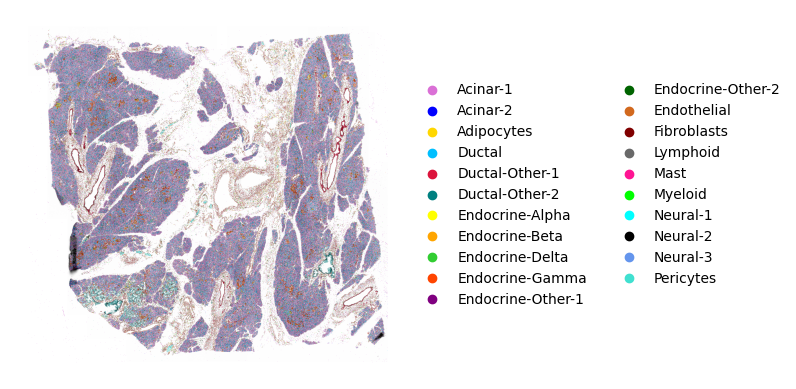

In [8]:
# Spatial plot without boundaries, cells are shown as dots colored by cell type
sc.pl.spatial(ad, color=['Celltype fine'], frameon=False, size=1, palette=palette_pancreas_fine, title='')

In [9]:
"""
# Date: 2025-06-06
# Organization: The Jackson Laboratory
# Author: Sergii Domanskyi

Description: This module provides functions to identify cells of interest based on their neighboring cell types
using a KDTree for efficient spatial queries. It also includes a function to visualize the results on a spatial layout.

Module spatialsearch is a part of spatial-omics-tools:
https://github.com/TheJacksonLaboratory/spatial-omics-tools
"""

import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from collections import defaultdict, deque

def find(df: pd.DataFrame, radius: int, threshold: float,
                celltype_column: str, x_column: str, y_column: str,
                interest_celltypes: list, neighbor_celltypes: list,
                verbose: bool=False) -> pd.Index:

    """Function to identify cells of interest based on their neighbors.
    Utilizes a KDTree for efficient spatial queries.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell data with columns for cell types and coordinates.

    radius : int
        Radius in micrometers to search for neighboring cells.

    threshold : float
        Proportion threshold of neighboring cells that must be of the specified types.

    celltype_column : str
        Name of the column in `df` that contains cell type information.

    x_column : str
        Name of the column in `df` that contains the x-coordinates of cells.

    y_column : str
        Name of the column in `df` that contains the y-coordinates of cells.

    interest_celltypes : list
        List of cell types to consider as 'interest' cells, e.g., Endocrine.

    neighbor_celltypes : list
        List of cell types that are considered as neighbors.

    verbose : bool, optional
        Whether to print progress and statistics, default is True.

    Returns
    -------
    pd.Index
        Index of cells that meet the criteria of having a sufficient 
        proportion of specified neighbor cell types.
    """

    interest_cells = df[df[celltype_column].isin(interest_celltypes)]

    tree = KDTree(df[[x_column, y_column]].values)

    a = df[celltype_column].isin(neighbor_celltypes).values
    idx = df.columns.get_loc(x_column)
    idy = df.columns.get_loc(y_column)

    found = []
    sizes = []
    with tqdm(total=len(interest_cells), desc='Searching', disable=not verbose) as pbar:
        for i, (index, row) in enumerate(interest_cells.iterrows()):
            if i % 10**3 == 0:
                pbar.update(10**3)

            neighbors_idx = tree.query_ball_point([row.values[idx], row.values[idy]], radius)
            sizes.append(len(neighbors_idx))
            proportion = a[neighbors_idx].mean()
            if proportion > threshold:
                found.append(index)

    if verbose:
        print('Average number of neighbors:', int(np.mean(sizes)))
        print('Number of cells found:', len(found))

    return pd.Index(found)

def find_neighbors(df: pd.DataFrame, radius: int,
                x_column: str, y_column: str,
                cells_of_interest: list,
                verbose: bool=False) -> pd.Index:

    """Function to find lists of neighbor cells for each cell of interest.
    Utilizes a KDTree for efficient spatial queries.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell data with columns for cell types and coordinates.

    radius : int
        Radius in micrometers to search for neighboring cells.

    x_column : str
        Name of the column in `df` that contains the x-coordinates of cells.

    y_column : str
        Name of the column in `df` that contains the y-coordinates of cells.

    cells_of_interest : list
        List of cell indices for which to find neighbors.

    verbose : bool, optional
        Whether to print progress and statistics, default is True.

    Returns
    -------
    dict
        Dictionary where keys are indices of interest cells and
        values are lists of indices of neighboring cells.
    """

    interest_cells = df.loc[cells_of_interest]

    tree = KDTree(df[[x_column, y_column]].values)

    idx = df.columns.get_loc(x_column)
    idy = df.columns.get_loc(y_column)

    found = {}
    with tqdm(total=len(interest_cells), desc='Searching', disable=not verbose) as pbar:
        for i, (index, row) in enumerate(interest_cells.iterrows()):
            if i % 10**3 == 0:
                pbar.update(10**3)

            neighbors_idx = tree.query_ball_point([row.values[idx], row.values[idy]], radius)
            found.update({index: df.index[neighbors_idx].values.tolist()})

    return found

def show(df: pd.DataFrame, cells: pd.Index,
        title: str, figsize=(8, 4), s: float=0.1,
        x_column: str='x_centroid', y_column: str='y_centroid',
        colors: list=['lightgrey', 'crimson'], labels: list=['Other', 'Found'],
        bounds=None, axes=False, legend=True, returnFig=False):

    """Function to visualize the identified cells on a sptial layout plot.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell data with columns for coordinates.

    cells : pd.Index
        Index of cells to highlight in the plot.

    title : str
        Title of the plot.

    figsize : tuple, optional
        Size of the figure, default is (8, 4).

    s : float, optional
        Size of the scatter points, default is 0.1.

    x_column : str
        Name of the column in `df` that contains the x-coordinates of cells.

    y_column : str
        Name of the column in `df` that contains the y-coordinates of cells.

    colors : list, optional
        List of colors for plotting, default is ['lightgrey', 'crimson'].

    labels : list, optional
        List of labels for the legend, default is ['Other', 'Found'].

    bounds : tuple, optional
        Bounds for the x and y axes in the format (xmin, xmax, ymin, ymax), default is None.

    axes : bool, optional
        Whether to show axes in the plot, default is False.

    legend : bool, optional
        Whether to display the legend, default is True.
    """

    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title, fontsize=20)

    if bounds is not None:
        ax.set_xlim(bounds[0], bounds[1])
        ax.set_ylim(bounds[2], bounds[3])
    
    ax.scatter(df[x_column], df[y_column], s=s, c=colors[0], alpha=1., label=labels[0])
    ax.scatter(df.loc[cells, x_column], df.loc[cells, y_column], s=s, c=colors[1], label=labels[1])

    ax.set_xlabel('X Centroid (µm)', fontsize=16)
    ax.set_ylabel('Y Centroid (µm)', fontsize=16)
    plt.xticks(fontsize=14, rotation=90)
    plt.yticks(fontsize=14)
    if legend:
        plt.legend(frameon=False, fontsize=14, markerscale=15,
                loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_aspect('equal')
    ax.invert_yaxis()
    plt.tight_layout()
    if not axes:
        plt.axis('off')

    if returnFig:
        return fig
    else:
        plt.show()

    return

def find_connected_components_with_threshold(graph_dict, min_connections=2):

    """Find connected components in a graph represented as an adjacency list.

    Parameters
    ----------
    graph_dict : dict
        Dictionary representing the graph where keys are nodes and values are lists of neighboring nodes.

    min_connections : int, optional
        Minimum number of connections required to keep a component together (default is 2).
    """

    # Build bidirectional adjacency list and collect all nodes
    adj, nodes = defaultdict(set), set()
    for n, nbrs in graph_dict.items():
        nodes.update([n] + nbrs)
        for nbr in nbrs:
            adj[n].add(nbr), adj[nbr].add(n)
    
    # Find connected components using BFS
    visited, components = set(), []
    for node in nodes:
        if node in visited: continue
        comp, q = [], deque([node])
        visited.add(node)
        while q:
            curr = q.popleft()
            comp.append(curr)
            for nbr in adj[curr]:
                if nbr not in visited:
                    visited.add(nbr), q.append(nbr)
        components.append(comp)
    
    # Split components with insufficient connections
    final = []
    for comp in components:
        if len(comp) <= 1 or sum(1 for n in comp for nbr in adj[n] if nbr in comp and n < nbr) >= min_connections:
            final.append(comp)
        else:
            final.extend([[n] for n in comp])
    
    return {f'C{i}': sorted(comp) for i, comp in enumerate(final)}

# Search for Endocrine cells connected to endocrine cells and determine their groups (i.e., islets)

In [10]:
endocrine_subtypes = ['Endocrine-Alpha', 'Endocrine-Beta', 'Endocrine-Delta', 'Endocrine-Gamma', 'Endocrine-Other-1', 'Endocrine-Other-2']
endocrine_cells = ad.obs.index[ad.obs['Celltype fine'].isin(endocrine_subtypes)]
found = find_neighbors(ad.obs, radius=16, x_column='x_centroid', y_column='y_centroid', cells_of_interest=endocrine_cells, verbose=True)

# Filter the found neighbors to only include those that are also endocrine cells
for cell in found.keys():
    found[cell] = [c for c in found[cell] if c in endocrine_cells]

# Find islets as connected components with at least 5 connections
result = find_connected_components_with_threshold(found, min_connections=5)

# Keep only islets with at least N cells
N = 10
large_components = {k: v for k, v in result.items() if len(v) >= N}
print(f'Found {len(result)} components, {len(large_components)} components with at least {N} cells..')

# Add islet annotations to AnnData
mapping = {}
for key, cells in large_components.items():
    for cell in cells:
        assert not cell in mapping, f'Cell {cell} already mapped to {mapping[cell]}.'
        mapping[cell] = key
ad.obs['Islet'] = ad.obs.index.map(mapping).fillna('Other')

Searching: 23000it [00:01, 15421.53it/s]                           


Found 4001 components, 361 components with at least 10 cells..


## Show all cells in a spatial plot, colored by islet membership

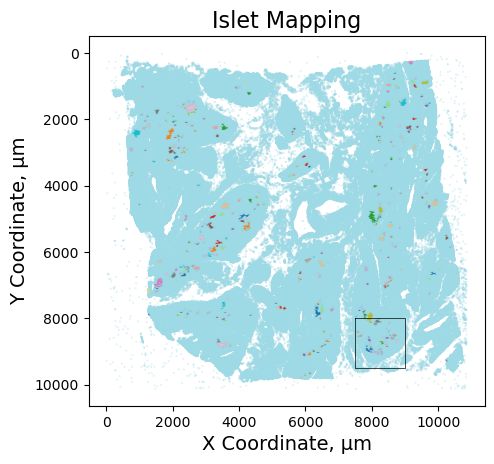

In [11]:
plt.scatter(ad.obsm['spatial'][:, 0], ad.obsm['spatial'][:, 1], s=0.1, c=ad.obs['Islet'].astype('category').cat.codes, cmap='tab20', alpha=0.5)
ax = plt.gca()
ax.set_title('Islet Mapping', fontsize=16)
ax.set_xlabel('X Coordinate, µm', fontsize=14)
ax.set_ylabel('Y Coordinate, µm', fontsize=14)
ax.invert_yaxis()
ax.set_aspect('equal')
x1, y1 = 7500, 8000
dx, dy = 1500, 1500
plt.plot([x1, x1 + dx, x1 + dx, x1, x1], [y1, y1, y1 + dy, y1 + dy, y1], color='black', linewidth=0.5)
plt.show()

## Zoom in to the region with islets, plot cells with segmented boundaries

Found 22879 cell boundaries in the specified region.


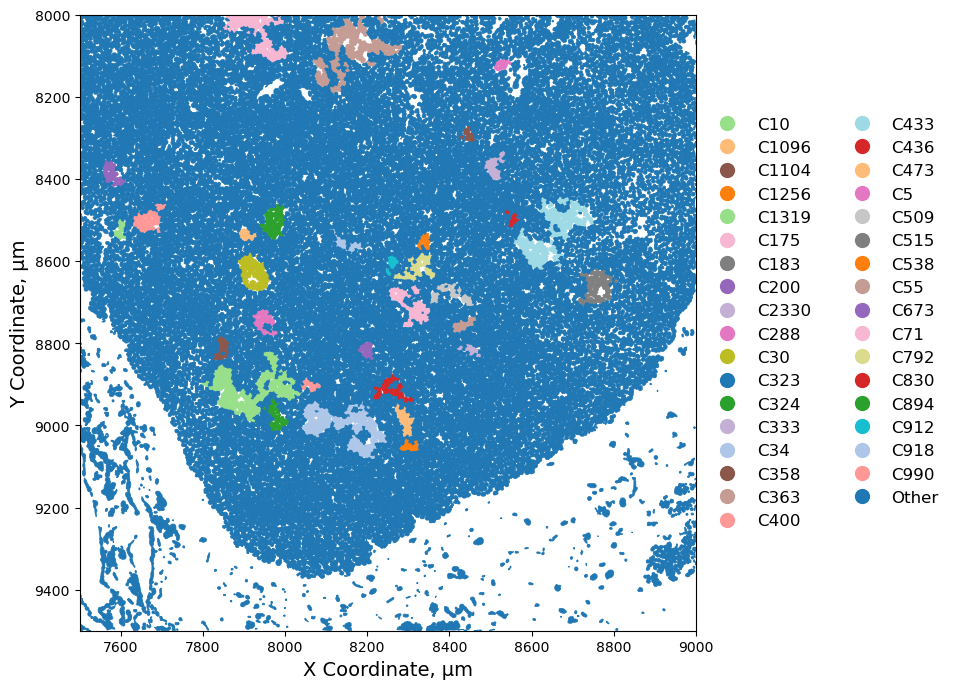

In [12]:
x1, y1 = 7500, 8000
dx, dy = 1500, 1500
plotWithBoundaries(ad, x1, x1 + dx, y1, y1 + dy, s=id, var='Islet', exclusion='',
                    dfb=ad.uns['df_cell_boundaries'], figsize=(8, 8), invert=False)

## Count number of cell of each endocrine celltype per islet

In [13]:
se = ad.obs[['Islet', 'Celltype fine']].value_counts()
se = se.loc[se.index.get_level_values(0) != 'Other']
df = se.unstack().fillna(0).astype(int).T
df.loc['Total'] = df.sum()

df.drop('Total').loc[:, np.random.choice(df.columns, size=30, replace=False)].style.background_gradient(cmap='Blues', axis=0).format('{:,.0f}').set_properties(**{'text-align': 'center'})

Islet,C184,C792,C543,C199,C113,C46,C512,C45,C87,C298,C877,C600,C843,C280,C528,C1146,C531,C208,C562,C542,C116,C83,C367,C527,C538,C26,C711,C619,C781,C315
Celltype fine,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Endocrine-Gamma,12,31,26,42,67,361,9,148,33,27,10,10,26,14,9,22,19,30,29,10,11,0,17,12,15,67,16,16,12,13
Endocrine-Alpha,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
Endocrine-Beta,0,0,0,7,1,8,0,4,2,0,0,0,0,0,2,2,0,2,2,0,0,10,0,0,0,41,2,0,0,0
Endocrine-Other-1,0,9,1,5,1,48,1,4,14,2,2,0,2,0,0,3,1,4,2,0,7,1,0,0,0,7,1,0,0,0
Endocrine-Other-2,0,0,0,0,1,3,0,3,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,2,0,0,2,0
Endocrine-Delta,0,0,1,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,6,0,0,0


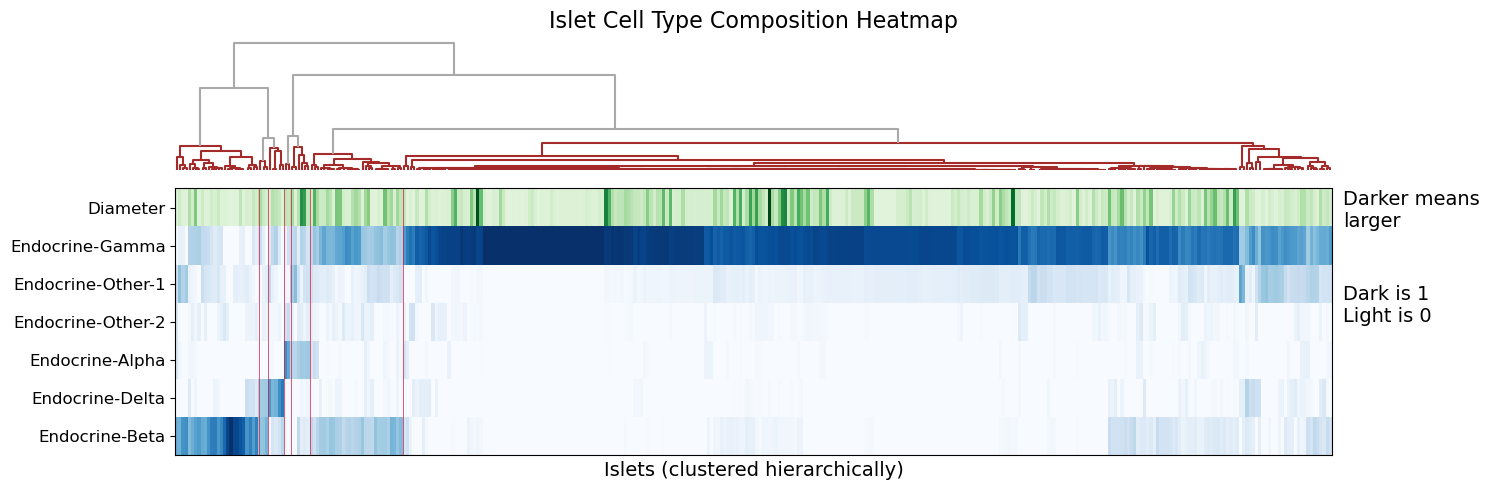

In [14]:
def plot_islets_composition_heatmap(df, th=0.1, link_colors=['red', 'teal', 'navy', 'gold', 'brown', 'pink', 'maroon', 'lime'], ct_colors='Blues', figsize=(15, 5)):

    """Plot a heatmap of islet cell type composition with hierarchical clustering.
    This function visualizes the composition of different cell types across islets,
    using hierarchical clustering to group similar islets together.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell type composition data for islets.

    th : float, optional
        Threshold for clustering distance (default is 0.1).

    link_colors : list, optional
        List of colors for the dendrogram links (default is ['red', 'teal', 'navy', 'gold', 'brown', 'pink', 'maroon', 'lime']).    

    ct_colors : list, optional
        List of colors for cell types (default is ['Greys', 'Reds', 'Oranges', 'Greens', 'Purples', 'YlOrBr', 'Blues']).
    """

    # Hierarchical clustering for columns (islets)
    col_dist = pdist(df.T, metric='correlation')
    col_link = linkage(col_dist, method='average')
    col_order = dendrogram(col_link, no_plot=True)['leaves']
    # Hierarchical clustering for rows (cell types)
    row_dist = pdist(df, metric='correlation') 
    row_link = linkage(row_dist, method='average')
    row_order = dendrogram(row_link, no_plot=True)['leaves']

    # Reorder data
    df_ordered = df.iloc[row_order, col_order]
    row_colors = ct_colors[::-1][:len(df_ordered)]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [1, 2]})
    hierarchy.set_link_color_palette(link_colors)
    dendrogram(col_link, orientation='top', ax=ax1, no_labels=True, color_threshold=th, above_threshold_color='darkgrey')
    ax1.set_ylabel('Islets')
    ax1.tick_params(labelleft=False)
    ax1.axis('off')
    ax1.set_title('Islet Cell Type Composition Heatmap', fontsize=16)

    ar = df_ordered.loc['Total'].values.reshape(1, -1)
    ar = np.sqrt(ar + 1)
    ar = ar / int(np.quantile(ar, 0.95))
    i = len(df_ordered) - 1
    ax2.imshow(ar, cmap='Greens', aspect='auto',
            extent=[0, ar.shape[1], i, i+1], vmin=0, vmax=ar.max())

    df_non_total = df_ordered.drop('Total')
    df_non_total_norm = df_non_total / df_non_total.sum(axis=0)
    for i, (idx, row) in enumerate(df_non_total_norm.iterrows()):
        ax2.imshow(row.values.reshape(1, -1), cmap=ct_colors, aspect='auto',
                extent=[0, len(row), i, i+1], vmin=0, vmax=1)

    ax2.set_xticks([])
    ax2.set_xticklabels([])
    ax2.set_yticks(np.arange(len(df_ordered)) + 0.5)
    ax2.set_yticklabels(df_ordered.index[:-1].tolist() + ['Diameter'], fontsize=12)
    ax2.set_xlabel('Islets (clustered hierarchically)', fontsize=14)
    ax2.set_ylim(0, len(df_ordered))

    clusters = np.sort(fcluster(col_link, t=th, criterion='distance'))
    locs = np.where((np.roll(clusters, 1) - clusters)<0)[0]
    for l in locs:
        ax2.axvline(l, color='crimson', linewidth=0.5)

    ax2.text(1.01 * df.shape[1], df.shape[0] - 1, 'Darker means\nlarger', fontsize=14, ha='left')
    ax2.text(1.01 * df.shape[1], df.shape[0] / 2, 'Dark is 1\nLight is 0', fontsize=14, ha='left')

    plt.tight_layout()
    plt.show()
    return

plot_islets_composition_heatmap(df, th=0.1, link_colors=['brown'])

## Find the largest islet and plot it with boundaries

In [15]:
def plot_islet(ad, islet, col='Islet', **kwargs):
    ar = ad.obsm['spatial'][ad.obs[col] == islet]
    x0, y0 = ar.min(axis=0)
    x1, y1 = ar.max(axis=0)
    dx, dy = x1 - x0, y1 - y0
    b = 0.05
    x0 -= dx * b
    x1 += dx * b
    y0 -= dy * b
    y1 += dy * b
    dx, dy = x1 - x0, y1 - y0

    plotWithBoundaries(ad, x0, x1, y0, y1, s=id, var='Celltype fine', exclusion='NA',
                        dfb=ad.uns['df_cell_boundaries'], invert=False, colormap=palette_pancreas_fine,
                        **kwargs)
    return

Found 1863 cell boundaries in the specified region.


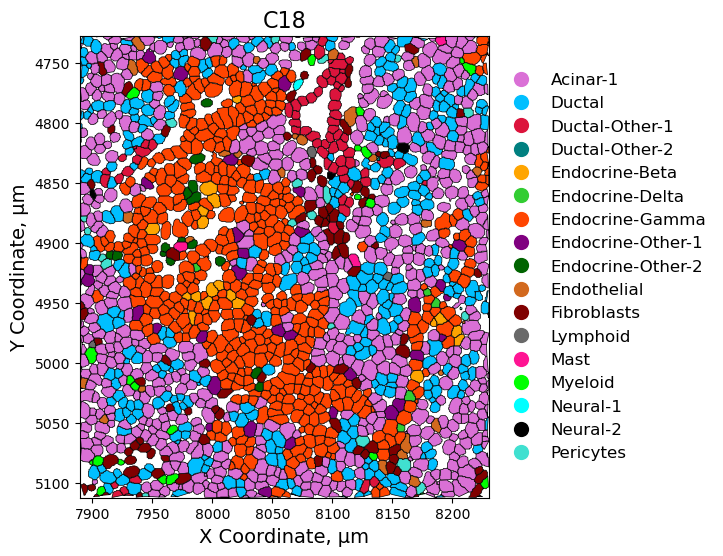

In [16]:
islet = df.columns[df.loc['Total'].argmax()]

plot_islet(ad, islet, figsize=(6, 6), title=islet)

## Find the largest beta cell-enriched islets

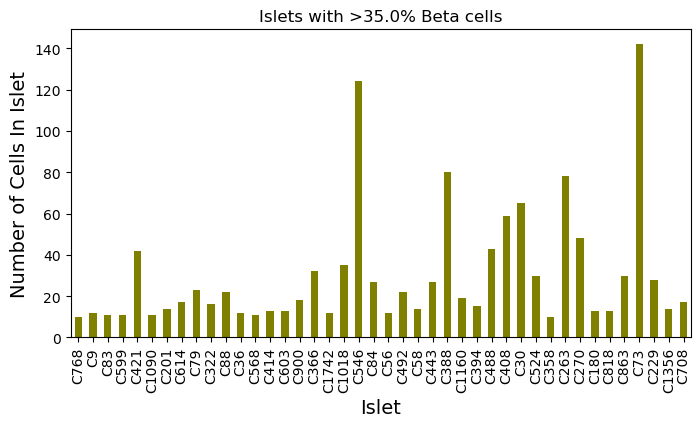

In [17]:
df_proportions = df.drop('Total').div(df.loc['Total'], axis=1)
se = df_proportions.loc['Endocrine-Beta'].sort_values(ascending=False)
thb = 0.35
se = df.loc['Total', se[se>thb].index]
se.plot(kind='bar', figsize=(8, 4), color='olive', title=f'Islets with >{thb*100}% Beta cells', legend=False)
ax = plt.gca()
ax.set_ylabel('Number of Cells In Islet', fontsize=14)
ax.set_xlabel('Islet', fontsize=14)
plt.show()

Found 89 cell boundaries in the specified region.


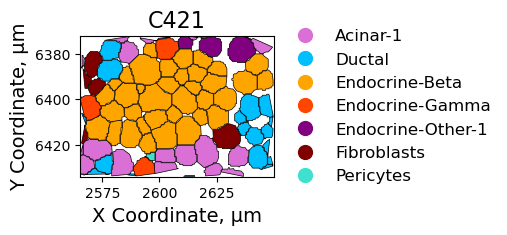

Found 277 cell boundaries in the specified region.


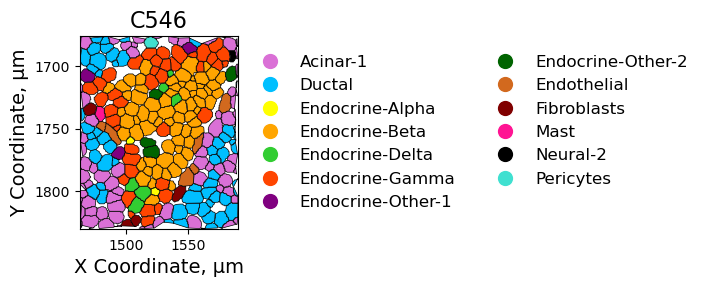

Found 299 cell boundaries in the specified region.


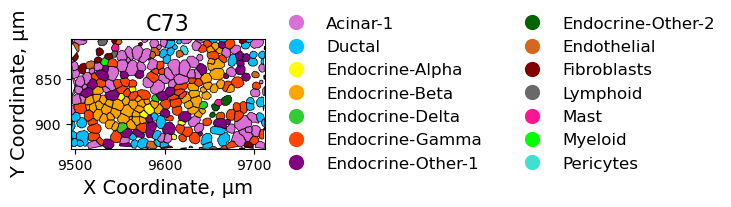

In [18]:
islet = se[:10].idxmax()
plot_islet(ad, islet, figsize=(2.5, 2.5), title=islet)

islet = se[:20].idxmax()
plot_islet(ad, islet, figsize=(2.5, 2.5), title=islet)

islet = se[:40].idxmax()
plot_islet(ad, islet, figsize=(2.5, 2.5), title=islet)

## For each islet, find and quantify other cell types that are present in and around the islet

In [19]:
endocrine_subtypes = ['Endocrine-Alpha', 'Endocrine-Beta', 'Endocrine-Delta', 'Endocrine-Gamma', 'Endocrine-Other-1', 'Endocrine-Other-2']
endocrine_cells = ad.obs.index[ad.obs['Celltype fine'].isin(endocrine_subtypes)]
found = find_neighbors(ad.obs, radius=16, x_column='x_centroid', y_column='y_centroid', cells_of_interest=endocrine_cells, verbose=True)

# Create a copy of the found neighbors to keep the original intact
found_all = found.copy()

# Filter the found neighbors to only include those that are also endocrine cells
for cell in found.keys():
    found[cell] = [c for c in found[cell] if c in endocrine_cells]

# Find islets as connected components with at least 5 connections
result = find_connected_components_with_threshold(found, min_connections=5)

# Keep only islets with at least N cells
N = 10
large_components = {k: v for k, v in result.items() if len(v) >= N}
print(f'Found {len(result)} components, {len(large_components)} components with at least {N} cells..')

for key in large_components.keys():
    cells_in_this_islet = large_components[key]
    all_this_cells = []
    for c in cells_in_this_islet:
        all_this_cells.extend(found_all[c])
    large_components[key] = list(set(all_this_cells))

# Add islet annotations to AnnData
mapping = {}
for key, cells in large_components.items():
    for cell in cells:
        if False:
            if cell in mapping:
                print(f'Cell {cell} already mapped to {mapping[cell]}.')
        mapping[cell] = key
ad.obs['Islet-extended'] = ad.obs.index.map(mapping).fillna('Other')

Searching: 23000it [00:01, 15431.12it/s]                           


Found 4001 components, 361 components with at least 10 cells..


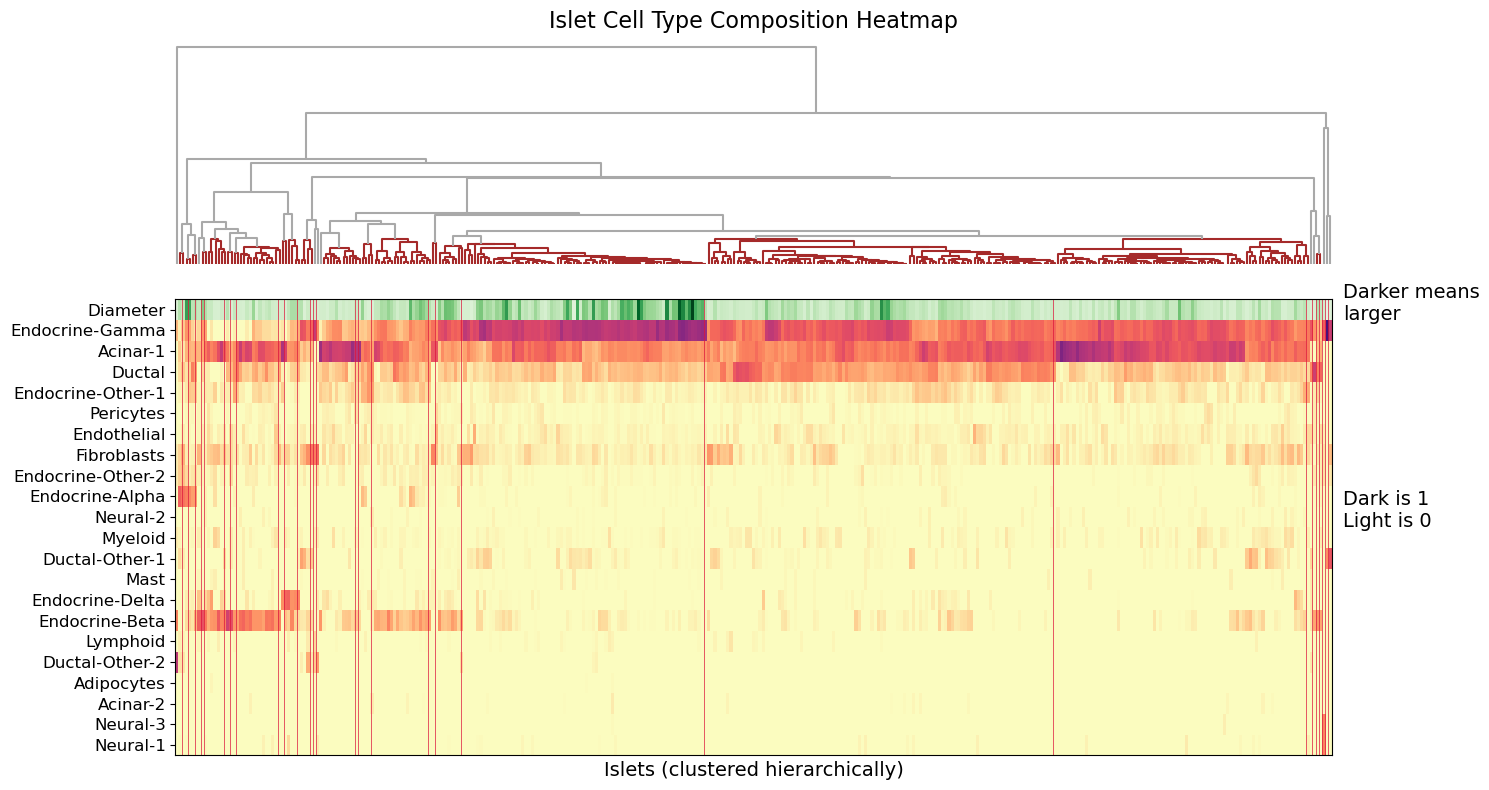

In [20]:
se = ad.obs[['Islet-extended', 'Celltype fine']].value_counts()
se = se.loc[se.index.get_level_values(0) != 'Other']
df = se.unstack().fillna(0).astype(int).T
df.loc['Total'] = df.sum()

plot_islets_composition_heatmap(df, th=0.025, link_colors=['brown'], figsize=(15, 8), ct_colors='magma_r')